# Comparing OMNY and MetroCard Usage across Demographics

**To run cells in this notebook from github, skip the preprocessing steps in sections 4, 5, 6 and go straight to loading these datasets from file.**
In each of these sections and their subsections, there will be a boldface markdown statement indicating where to start running cells.
- Also skip the first cell in section 3.1, skip sections 3.2, 3.3, and 3.4 entirely

# 1. Installing and importing necessary libraries

In [190]:
!pip install pandas 
!pip install sodapy
!pip install censusdata
!pip install geopandas
!pip install folium matplotlib mapclassify
!pip install geodatasets

In [570]:
import pandas as pd
from sodapy import Socrata
import geopandas as gpd
import geodatasets
from shapely.geometry import Point
import requests
import matplotlib.pyplot as plt
import matplotlib
import folium
import mapclassify
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from datetime import datetime

# 2. Loading MTA Subway Data
MTA Data used in this project is from the Subway Hourly Ridership (beginning February 2022) at <https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-February-202/wujg-7c2s>

## 2.1 With App Token

In [313]:
nys_client = Socrata("data.ny.gov", None)

In [218]:
#ep_client = Socrata()

The following function retrieves a list of station complexes and non-complex stations in the NYC Subway and Staten Island Railroad

In [3]:
def get_station_list(client):
    results = client.get("5f5g-n3cz")
    results_df = pd.DataFrame.from_records(results)
    station_list = results_df['complex_id'].values.tolist()
    return station_list

The following functions retrieve all data for one station, and a sample. `client` parameter for the client, `station_complex_id` parameter for the station complex id. 

In [4]:
def get_station_data(client, station_complex_id, batch_size=100000):
    """retrieves all relevant data for one station using station_complex_id"""
    results = []
    where_string = "station_complex_id = '" + str(station_complex_id) + "'"
    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size)
    i = 0
    while len(this_batch) > (batch_size - 1):
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df

def get_station_sample(client, station_complex_id, size=5000):
    """retrieves small sample relevant data for one station using station_complex_id.
        Will retrieve limit data points, used for testing on smaller sample"""
    results = []
    where_string = "station_complex_id = '" + str(station_complex_id) + "'"
    results = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=size)
    results_df = pd.DataFrame.from_records(results)
    return results_df

The below functions retrieve relevant data for one station, with timestamp filters:
1. The first filters by date (start and end date)
2. The second filters by date (start and end date) and time (times of day for all dates in date range, start and end)

In [5]:
def get_station_data_dates(client, station_complex_id, batch_size=100000, start_date="2024-09-01", end_date="2024-09-30"):
    """retrieves all relevant data for one station during the date range using station_complex_id"""
    results = []
    where_string = (
        f"station_complex_id = '{str(station_complex_id)}' "
        f"AND transit_timestamp >= '{start_date}' "
        f"AND transit_timestamp <= '{end_date}'"
    )

    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size)
    i = 0
    while len(this_batch) > (batch_size - 1):
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df


def get_station_data_dates(client, station_complex_id, batch_size=100000,
                           start_date="2024-09-01", end_date="2024-09-30",
                          start_time='08:00:00', end_time='10:00:00'):
    """retrieves all relevant data for one station during the date range using station_complex_id"""
    results = []
    where_string = (
        f"station_complex_id = '{str(station_complex_id)}' "
        f"AND transit_timestamp >= '{start_date}' "
        f"AND transit_timestamp <= '{end_date}'"
        f"AND time(transit_timestamp) >= '{start_time}' "
        f"AND time(transit_timestamp) <= '{end_time}'"
    )

    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size)
    i = 0
    while len(this_batch) > (batch_size - 1):
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df  

The funciton below gets data for all stations, using a date range

In [6]:
def get_data(client, batch_size=100000, max_retries=3, start_date="2024-09-01", end_date="2024-09-30"):
    """retrieve data for all stations, with a given start and end date
        Note: retries should at most be n where 10^n is <= batch_size"""
    station_list = get_station_list(client)

    results = []
    failed_stations = []
    for station in station_list:
        retry_count = 0
        success = False
        this_station_result = []
        
        where_string = (f"station_complex_id = '{str(station)}' "
            f"AND transit_timestamp >= '{start_date}' "
            f"AND transit_timestamp <= '{end_date}'"
            )

        while (not success) and (retry_count < max_retries):
            try:
                this_station_result = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=batch_size)
                success = True
            except Exception as e:
                retry_count += 1
                if retry_count == max_retries:
                    failed_stations += [station]

        this_df = pd.DataFrame(this_station_result)
        results += [this_df]
    
    results_df = pd.concat(results, ignore_index=True)

    return results_df, failed_stations

The next function is a special case where we retrieve the first of every month in the dataset

In [492]:
from datetime import datetime, timedelta

def get_date_list(start_date='2022-02-01', end_date='2024-09-01'):
    dates = []
    current_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        # Move to the next month
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)
    
    return dates

In [520]:
def get_timeline_data(client, batch_size=100000, max_retries=3):
    """retrieve data for all stations, with a given start and end date
        Note: retries should at most be n where 10^n is <= batch_size"""
    station_list = get_station_list(client)

    results = []
    failed_stations = []
    for station in station_list:
        retry_count = 0
        success = False
        this_station_result = []
        
        date_list = get_date_list()

        while (not success) and (retry_count < max_retries):
            try:
                for date in date_list:
                    where_string = (f"station_complex_id = '{str(station)}' "
                                    f"AND transit_timestamp >= '{date}T00:00:00' "
                                    f"AND transit_timestamp < '{date}T23:59:59'")
                    this_station_result += client.get("wujg-7c2s", order="transit_timestamp ASC", where=where_string, limit=batch_size)
                success = True
            except Exception as e:
                retry_count += 1
                if retry_count == max_retries:
                    failed_stations += [station]

        this_df = pd.DataFrame(this_station_result)
        results += [this_df]
    
    results_df = pd.concat(results, ignore_index=True)

    return results_df, failed_stations

## 2.2 Without app token
The functions in this section have been modified to account for a client without an app token.

In [20]:
nys_client = Socrata("data.ny.gov", None) #create client for MTA data

There is a limit of 1000 rows that can be retrieved at once using the API provided by New York State without an app token. The functions below retrieve (1) all of the relevant data (in batches of 1000) for a station and (2) a small sample of the data that might be easier to work with.
Both are sorted by date in descending order (meaning the small sample will use the most recent data)

In [6]:
def get_station_data_nt(client, station_complex_id):
    """retrieves all relevant data for one station using station_complex_id"""
    results = []
    where_string = "station_complex_id = '" + str(station_complex_id) + "'"
    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000)
    i = 0
    while len(this_batch) > 999:
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df

def get_station_sample_nt(client, station_complex_id):
    """retrieves small sample relevant data for one station using station_complex_id.
        Will retrieve 1000 data points, used for testing on smaller sample"""
    results = []
    where_string = "station_complex_id = '" + str(station_complex_id) + "'"
    results = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

For this analysis, we may want to use a smaller date range due to limited compute resources. We may also want to use a specific time range during that date. The following functions retrieve station data in a date range (1) and a time range within a date range (2).

In [109]:
def get_station_data_dates_nt(client, station_complex_id, start_date="2024-09-01", end_date="2024-09-30"):
    """retrieves all relevant data for one station during the date range using station_complex_id"""
    results = []
    where_string = (
        f"station_complex_id = '{str(station_complex_id)}' "
        f"AND transit_timestamp >= '{start_date}' "
        f"AND transit_timestamp <= '{end_date}'"
    )

    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000)
    i = 0
    while len(this_batch) > 999:
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df


def get_station_data_dates_nt(client, station_complex_id, 
                           start_date="2024-09-01", end_date="2024-09-30",
                          start_time='08:00:00', end_time='10:00:00'):
    """retrieves all relevant data for one station during the date range using station_complex_id"""
    results = []
    where_string = (
        f"station_complex_id = '{str(station_complex_id)}' "
        f"AND transit_timestamp >= '{start_date}' "
        f"AND transit_timestamp <= '{end_date}'"
        f"AND time(transit_timestamp) >= '{start_time}' "
        f"AND time(transit_timestamp) <= '{end_time}'"
    )

    this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000)
    i = 0
    while len(this_batch) > 999:
        results += this_batch
        this_batch = client.get("wujg-7c2s", order="transit_timestamp DESC", where=where_string, limit=1000, offset=len(results))

    results += this_batch
    results_df = pd.DataFrame.from_records(results)
    return results_df  

## 2.3 Formatting MTA Data

The following functions are used to preprocess the MTA data's geometry for use in geopandas

In [8]:
def format_geodata(mta_df):
    """takes a DataFrame of station data and formats the georeference"""
    points = []
    for index, row in mta_df.iterrows():
        new_point = Point(row['longitude'], row['latitude'])
        points += [new_point]
    mta_df['geometry'] = points
    return gpd.GeoDataFrame(mta_df, geometry="geometry", crs="EPSG:4326")

def quick_format_geodata(mta_df):
    """takes a DataFrame of station data FROM ONE STATION ONLY and formats the georeference"""
    point = Point(mta_df.iloc[0]['longitude'], mta_df.iloc[0]['latitude'])
    mta_df['geometry'] = len(mta_df) * [point]
    return gpd.GeoDataFrame(mta_df, geometry="geometry", crs="EPSG:4326")

The next step is useful to analysis at a station-by-station level (and not a ZCTA level): compiling this data at by station (or station complex where applicable). This is done in the function below

In [593]:
def method_by_station(mta_gdf):
    """takes a GeoDataFrame of subway station data and creates a new GeoDataFrame
        where each row represents one subway station"""
    new_cols = ["station_complex_id", "station_complex", "metrocard", "omny", "Total_Ridership",
                "omny_ratio", "borough", "georeference"]
    new_df = pd.DataFrame(columns=new_cols)
    new_df.set_index("station_complex_id", inplace=False)

    for index, row in mta_gdf.iterrows():
        payment_method = row['payment_method']
        ridership = int(float(row['ridership']))
        fare_class_category = row['fare_class_category']
        
        station_complex_id = row['station_complex_id']

        if not(station_complex_id in new_df.index): #create a new row for this index
            georeference = row["geometry"]
            station_complex = row['station_complex']
            new_row = {"station_complex_id": station_complex_id, "station_complex": station_complex, 
                       "borough": row["borough"], "georeference": georeference}
            for col in new_df.columns:
                if col not in new_row:
                    new_row[col] = 0

            new_row_df = pd.DataFrame([new_row], index=[new_row['station_complex_id']])
            new_df = pd.concat([new_df, new_row_df])

        new_df.at[station_complex_id, payment_method] += ridership #add the ridership to the correct method
        new_df.at[station_complex_id, "Total_Ridership"] += ridership #add to the total ridership

        if fare_class_category not in new_df.columns:
            new_df[fare_class_category] = 0
        new_df.at[station_complex_id, fare_class_category] += ridership

    omny_ratio = []
    for index, row in new_df.iterrows():
        this_ratio = row['omny']/ row['Total_Ridership']
        omny_ratio += [this_ratio]
        
    new_df['omny_ratio'] = omny_ratio

    new_gdf = gpd.GeoDataFrame(new_df, geometry='georeference', crs="EPSG:4326")
    return new_gdf

# 3. Loading Census Data
The following demographic information is considered according to zip code tabulation area: income

## 3.1 Getting Zip Code Tabulation Areas
Zip Code Tabulation Area (ZCTA) shapefile from TIGER/Line Shapefiles at <https://www.census.gov/cgi-bin/geo/shapefiles/index.php>

Click [here](https://data.census.gov/map/040XX00US36$8600000/DECENNIALDHC2020/P1?layer=VT_2020_860_00_PY_D1&loc=40.7338,-73.8244,z9.4097) to see a map of ZCTAs in New York (Default map is population of each ZCTA).

In [10]:
#loading the paths from shapefile
zcta_path = "tl_2020_us_zcta520/tl_2020_us_zcta520.shp"
zcta_gdf = gpd.read_file(zcta_path)
zcta_gdf = zcta_gdf.to_crs("EPSG:4326")

The following function is used to label each point of a GeoDataFrame with the corresponding ZCTA, i.e. what ZCTA a subway station is located in. This column will probably be labelled **ZCTA5CE20**.

In [11]:
def zcta_join(mta_gdf, zcta_gdf):
    """takes two GeoDataFrames: with subway data (mta_gdf) and with ZCTA boundaries (zcta_gdf)
    and adds a column to mta_gdf that contains the ZCTA wherein a data point was recorded"""
    new_gdf = gpd.sjoin(mta_gdf, zcta_gdf, how="left", predicate="within")
    return new_gdf

After we label the MTA data with the corresponding ZCTA, we can make a new GeoDataFrame where each row is one ZCTA and associated MTA Data (`method_by_zcta`). This will allow comparisons to be made across demographic factors

In [229]:
def method_by_zcta(joined_gdf, zcta_gdf, zcta_col_name="ZCTA5CE20"):
    """Creates a GeoDataFrame with zip code tabulation areas and the use of each payment method.
        Geometry will be that of the zcta"""
    new_cols = ["zcta", "metrocard", "omny", "Total_Ridership", "omny_ratio", "georeference",
               "station_complexes", "station_complex_ids", "borough"]
    new_df = pd.DataFrame(columns=new_cols)
    new_df.set_index("zcta", inplace=False)
    
    for index, row in joined_gdf.iterrows():
        
        payment_method = row['payment_method']
        ridership = int(float(row['ridership']))
        fare_class_category = row['fare_class_category']
        zcta = row[zcta_col_name]
        station_complex = row['station_complex']
        station_complex_id = row['station_complex_id']
        
        if not(zcta in new_df.index): #create a new row if this ZCTA hasn't been encountered
            georeference = zcta_gdf.loc[zcta_gdf[zcta_col_name] == zcta, 'geometry'].values[0]
            new_row = {"zcta" : zcta, "georeference": georeference, "station_complexes": [], 
                       "station_complex_ids": [], "borough": row['borough']}
            for col in new_df.columns:
                if col not in new_row:
                    new_row[col] = 0
            new_row_df = pd.DataFrame([new_row], index=[new_row['zcta']])
            new_df = pd.concat([new_df, new_row_df])
        
        new_df.at[zcta, payment_method] += ridership #add the ridership to the correct method
        new_df.at[zcta, "Total_Ridership"] += ridership #add to the total ridership

        if station_complex_id not in new_df.at[zcta, 'station_complex_ids']:
            new_df.at[zcta, 'station_complex_ids'] += [station_complex_id]
            new_df.at[zcta, 'station_complexes'] += [station_complex]

        if not(fare_class_category in new_df.columns):
            new_df[fare_class_category] = 0
        new_df.at[zcta, fare_class_category] += ridership

    omny_ratio = []
    for index, row in new_df.iterrows():
        this_ratio = row['omny']/ row['Total_Ridership']
        omny_ratio += [this_ratio]
        
    new_df['omny_ratio'] = omny_ratio
        
    new_gdf = gpd.GeoDataFrame(new_df, geometry='georeference', crs="EPSG:4326")
    return new_gdf
    

In [395]:
def add_census_data(method_gdf, census_df, census_col_name, new_col_name, type='int'):
    """Adds census data to a GeoDataFrame that has come from method_by_zcta()"""
    new_data = []
    for index, row in method_gdf.iterrows():
        this_zcta = row['zcta']
        this_val = 0
        if type =='int':
            this_val = int(census_df.loc[census_df['NAME'] == 'ZCTA5 ' + this_zcta, census_col_name].values[0])
        elif type == 'float':
            this_val = float(census_df.loc[census_df['NAME'] == 'ZCTA5 ' + this_zcta, census_col_name].values[0])
        if this_val < 0:
            this_val = 0
        new_data += [this_val]

    method_gdf[new_col_name] = new_data
    return method_gdf

## 3.2 Loading Census Income Data

In [13]:
income_url = "https://api.census.gov/data/2022/acs/acs5/subject?get=group(S1901)&ucgid=pseudo(0400000US36$8600000)"
income_response = requests.get(income_url)

In [14]:
income_data = income_response.json()
income_df = pd.DataFrame(income_data[1:], columns=income_data[0])

A number of empty columns appear in this data, the following function is used to remove them (most have the value `None` but a few other values appear)

In [260]:
def census_data_cleaner(df, empty_list):
    """removes columns that have no data from census data dataframes"""
    empty_cols = list(df)
    for index, row in df.iterrows():
        for col in empty_cols:
            if not(row[col] in empty_list):
                empty_cols.remove(col)

    df = df.drop(columns=empty_cols)
    return df

empty_list = [None, "(X)", "**", "***", "-", "N"]

In [16]:
income_df = census_data_cleaner(income_df, empty_list)

The columns are not intutively named, so the following is used to find the column with median household income. ZCTA 10002 has a median household income of 43362. This is in column **S1907_C01_12E**. 

In [17]:
for col in list(income_df):
    if income_df.iloc[2][col] == "43362":
        print("Median Household Income Column: " + str(col))
        break

Median Household Income Column: S1901_C01_012E


The following function adds census data to a gdf that has been processed in `method_by_zcta`

## 3.3 Loading Census Age data

In [249]:
age_url = "https://api.census.gov/data/2022/acs/acs5/subject?get=group(S0101)&ucgid=pseudo(0400000US36$8600000)"
age_response = requests.get(age_url)

In [250]:
age_data = age_response.json()
age_df = pd.DataFrame(age_data[1:], columns=age_data[0])

Similar to income, a number of empty columns appear. We can use the same function to clean them

In [261]:
age_df = census_data_cleaner(age_df, empty_list + [888888888])

Again, the columns are not intuitively named, so we can use similar code to find the Median Age as well as percent between 18 and 24. These are:
- Median age: **S0101_C01_032E**
- 18 to 24 years: **S0101_C02_023E**

In [265]:
for col in list(age_df):
    if age_df.iloc[2][col] == "44.2":
        print("Median Age: " + str(col))
    if age_df.iloc[2][col] == '7.2' and age_df.iloc[1][col] == '11.5':
        print("18 - 24 range: " + str(col))

Median Age: S0101_C01_032E
18 - 24 range: S0101_C02_023E


## 3.4 Population and Area
We can also try population and area, which will be useful for population density

In [325]:
area_url = "https://api.census.gov/data/2023/geoinfo?get=group(GEOINFO)&ucgid=pseudo(0400000US36$8600000)"
pop_url = "https://api.census.gov/data/2020/dec/dhc?get=group(P1)&ucgid=pseudo(0400000US36$8600000)"

area_response = requests.get(area_url)
pop_response = requests.get(pop_url)

In [326]:
area_data = area_response.json()
pop_data = pop_response.json()

area_df = pd.DataFrame(area_data[1:], columns=area_data[0])
pop_df = pd.DataFrame(pop_data[1:], columns=pop_data[0])

These DataFrames have far fewer columns, and it is not necessary to clean them. Furthermore, the columns in `area_df` are intuitively named:
**Area**
- `AREALAND` for land area in square meters
- `AREALAND_SQMI` for land area in square miles
- `AREAWATER` and `AREAWATER_SQMI` for water area in these units

And `pop_df` has only one column with population data, named `P1_001N`

# 4. Comparing Fare Methods within MTA Data
We can compare the rates of OMNY usage across stations (or complexes, where relevant) in the System

## 4.1 Preprocessing
The following set of functions and calls preprocesses the data for analysis. These steps may take a lot of time

In [167]:
def get_subway_jgdf(client, batch_size=100000):
    """gets the joined GeoDataFrame where each data point is labelled by ZCTA"""
    subway_df, failed_stations = get_data(client, batch_size=batch_size)
    print("MTA data retrieved")
    if len(failed_stations) > 0:
        print("Stations unsuccessfully retrieved: " + str(failed_stations))
    subway_gdf = format_geodata(subway_df)
    subway_jgdf = zcta_join(subway_gdf, zcta_gdf)
    print("MTA data preprocessed")
    return subway_jgdf

If you have not initialized the client above, run the following cell. Otherwise, skip the cell below.
If you have an app token to `data.ny.gov`, uncomment the second line and use your app token, username, and password.

In [ ]:
slow_client = Socrata("data.ny.gov", None) #create client for MTA data. 
#fast_client = Socrata("data.ny.gov", "<App Token>", username="<username>", password="<password>") #replace this line if you have an app token

The following cells load and process the MTA turnstile data (this process may a while). In this section, data is computed by station.

In [166]:
if 'fast_client' in globals():
    subway_jgdf = get_subway_jgdf(fast_client)
else:
    subway_jgdf = get_subway_jgdf(slow_client, batch_size=1000)

In [ ]:
subway_jgdf = get_subway_jgdf(ep_client) # This may take a significant amount of time

In [37]:
subway_station_gdf = method_by_station(subway_gdf) #this also might take a significant amount of time

The following cell is a preview of the data

In [52]:
subway_station_gdf #run this cell to see a preview of the data

### 4.1.1 Exporting and Importing Results
To save time when away, the results can be exported
**To run this from GitHub, only import subway_station_gdf from file**

In [215]:
# export to file
subway_station_gdf.to_file('subway_station_gdf.gpkg', driver='GPKG') # by subway station

In [ ]:
# import from file
subway_station_gdf = gpd.read_file('subway_station_gdf.gpkg') # by subway station

We can also do this for the data where each line represents one hour's ridership at one station for one fare class and payment method. This might take linger to save and import.

In [ ]:
subway_jgdf.to_file('subway_jgdf.gpkg', driver='GPKG') # each row from MTA data

In [ ]:
subway_jgdf = gpd.read_file('subway_jgdf.gpkg') # each row from MTA data

## 4.2 Mapping Results
We can plot the Omny Ratio (number of OMNY uses out of total fare payments) for each available station

In [171]:
def pretty_map(data, this_parameter, cmap='plasma', legend_title=None, mark_size=12, title=None):
    legend_kw = {'label': legend_title, 'orientation':'vertical'}
    fig, ax = plt.subplots(1, 1)
    plot = data.plot(this_parameter, cmap=cmap, legend=True, markersize=mark_size, legend_kwds=legend_kw, ax=ax)
        
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_frame_on(True)  # Ensure the boundary is visible
    plt.title(title)
    

Note: as fares on the Staten Island Railroad are only collected at St. George and Tompkinsville, these are the only SIR stations mapped.

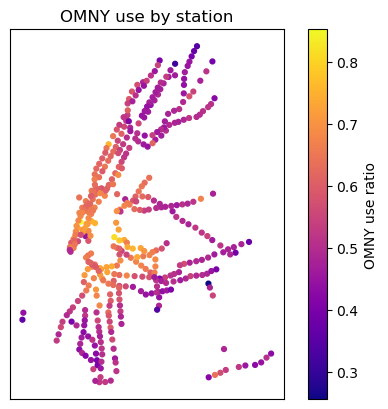

In [528]:
pretty_map(subway_station_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by station')

We can plot Manhattan alone to better visualize denser regions.

Note that the color scale adjusts for the Manhattan-only data

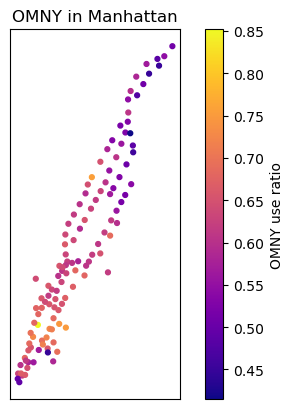

In [113]:
pretty_map(subway_station_gdf.loc[subway_station_gdf['borough'] == 'Manhattan'], 'omny_ratio', legend_title='OMNY use ratio', title='OMNY in Manhattan')

We may want to observe the stations with the highest and lowest rates of OMNY use. Change `RANK_DEPTH` to show more or fewer top / bottom stations

In [214]:
RANK_DEPTH = 10
def print_extreme_stations(data, depth, metric='omny_ratio'):
    top_stations = data.nlargest(RANK_DEPTH, 'omny_ratio')
    bottom_stations = data.nsmallest(RANK_DEPTH, 'omny_ratio')[::-1]
    print("Top and bottom stations by " + metric)
    i = 1
    for index, row in top_stations.iterrows():
        print(str(i)+ ". " + row['station_complex'] + " at " + str(round(row[metric], 3)))
        i += 1
    i = RANK_DEPTH - 1
    leng = len(data)
    print("...")
    for index, row in bottom_stations.iterrows():
        print(str(leng - i) + ". " + row['station_complex'] + " at " + str(round(row[metric], 3)))
        i -= 1

print_extreme_stations(subway_station_gdf, RANK_DEPTH)

Top and bottom stations by omny_ratio
1. W 4 St-Wash Sq (A,C,E,B,D,F,M) at 0.852
2. Bedford Av (L) at 0.812
3. Lorimer St (L)/Metropolitan Av (G) at 0.776
4. 116 St-Columbia University (1) at 0.755
5. Morgan Av (L) at 0.753
6. 1 Av (L) at 0.75
7. 3 Av (L) at 0.745
8. Classon Av (G) at 0.741
9. Graham Av (L) at 0.74
10. Central Av (M) at 0.734
...
417. 233 St (2,5) at 0.397
418. Jamaica Center-Parsons/Archer (E,J,Z) at 0.393
419. Eastchester-Dyre Av (5) at 0.391
420. Nereid Av (2,5) at 0.377
421. Jamaica-179 St (F) at 0.375
422. Tompkinsville (SIR) at 0.362
423. Wakefield-241 St (2) at 0.345
424. Canarsie-Rockaway Pkwy (L) at 0.344
425. Woodlawn (4) at 0.312
426. Aqueduct Racetrack (A) at 0.256


To view the data interactively, run the following cell

In [202]:
m_kwds = {'radius':100, 'fill': True}
subway_station_gdf.explore('omny_ratio', cmap='plasma', tiles='CartoDB positron', marker_type='circle', marker_kwds=m_kwds)

We can observe several things:
- Stations closer to CBD have higher OMNY adoption rates. This is especially true for neighborhoods between Midtown and Downtown.
- Williamsburg and Greenpoint have higher OMNY adoption rates than other areas of Brooklyn that are a similar distance from lower Manhattan. In fact, many of the stations in the top 10 (by OMNY use rate) are along the BMT Canarsie Line in Williamsburg
- 116 St (1) - Columbia University has a higher OMNY adoption rate than the surrounding stations. This could suggest Columbia students have adopted OMNY faster than the average riders.
- W 4 St - Washington Sq (A, C, E, B, D, F, M) has the highest OMNY use rate in the system. This, along with the previous observation, could indicate higher education students use OMNY at a higher rate (this is one of several stations close to NYU buildings), however this pattern does not hold as strong for 8th St NYU (R, W) or Astor Pl (6). Other stations named after colleges and universities do not appear to exhibit this pattern, except for maybe Bedford Park Blvd - Lehman College (4), which has a slightly higher OMNY use rate than surrounding stations.
- Grand St (B, D) has a much lower OMNY use rate than other stations in the Lower East Side.
- Bowling Green (4, 5) and South Ferry (1) / Whitehall St (R / W) have lower OMNY use than the rest of the Financial District. One possible explanation is that Staten Island Railroad riders, transferring from the ferry, are responsible for this. At the two fare-collecting stations in Staten Island, OMNY use rates are much lower than those of Financial District stations.
- Mets-Willets Point (7) has a higher OMNY use rate (~67%) than nearby stations (46-52%) on the 7 train. This is likely due to riders going to Mets games, and not residents of Corona or Flushing. 161 St - Yankee Stadium (B, D, 4) does not exhibit a similar pattern: this station has an OMNY use rate only marginally higher than surrounding stations (though the environs of this station suggest greater local use).
- Aqueduct Racetrack (A) has the lowest OMNY adoption rate in the system, significantly lower than other nearby stations. This is likely due to riders going to Aqueduct Racetrack, and not residents of Ozone Park.

We may want to see the system overall OMNY use ratio as a standard of comparison for later analysis. For September 2024, it is about **59%**

In [116]:
def average_omny_ratio(data_gdf):
    """gets the average OMNY ratio for a GeoDataFrame created by method_by_station()
        or method_by_zcta()"""
    total_omny = 0
    total_all = 0
    for index, row in data_gdf.iterrows():
        total_omny += row['omny']
        total_all += row['Total_Ridership']
    result = total_omny / total_all
    return result

In [118]:
overall_omny_rate = average_omny_ratio(subway_station_gdf)
print("System OMNY Ratio: " + str(overall_omny_rate))

System OMNY Ratio: 0.5946224416942202


We can also compare across Boroughs

In [846]:
def boro_omny_ratio(data_gdf):
    """determines system OMNY ratio for certain borough"""
    counts = {'Bronx': [0,0], 'Brooklyn': [0,0], 'Manhattan': [0,0], 'Queens': [0,0], 'Staten Island': [0,0],}
    for index, row in data_gdf.iterrows():
        this_total = row['Total_Ridership']
        this_omny = row['omny']
        counts[row['borough']][0] += this_total
        counts[row['borough']][1] += this_omny
    rates = {}
    for boro in counts:
        rates[boro] = counts[boro][1] / counts[boro][0]
    return rates

In [847]:
borough_rates = boro_omny_ratio(subway_station_gdf)
for boro in borough_rates:
    print(boro + " OMNY rate: " + str(round(borough_rates[boro], 4)))

Bronx OMNY rate: 0.4774
Brooklyn OMNY rate: 0.5914
Manhattan OMNY rate: 0.6313
Queens OMNY rate: 0.5258
Staten Island OMNY rate: 0.4371


In [858]:
def pretty_bar(x, y, color='#0039A5', width=0.4, title=None, ylabel=None, xlabel=None, horiz=False, figsize=(8,4)):
    plt.figure(figsize=figsize)
    if horiz:
        plt.barh(x, y, color=color, height=width)
    else:
        plt.bar(x, y, color=color, width=width)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()


We can graph and map this data and observe somewhat similar rates by boro

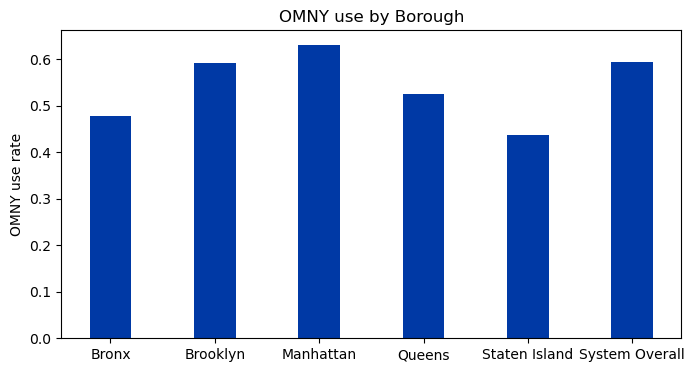

In [855]:
pretty_bar(list(borough_rates.keys()) + ['System Overall'], list(borough_rates.values()) + [overall_omny_rate],
          title="OMNY use by Borough", ylabel="OMNY use rate")

In [849]:
boro_gdf = gpd.read_file(geodatasets.get_path('ny.bb')).sort_values('BoroName')
boro_gdf['omny_ratio'] = [borough_rates[key] for key in borough_rates]

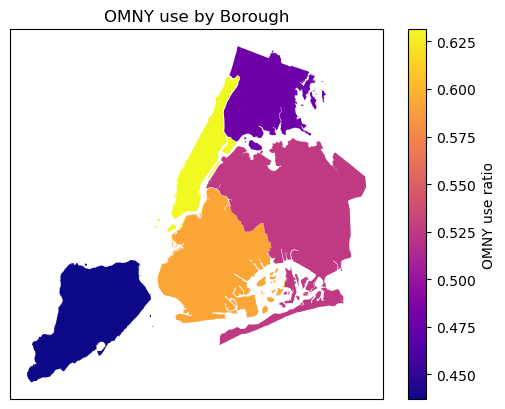

In [851]:
pretty_map(boro_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by Borough')

## 4.3 Fare Classes: Student, Senior & Disability, Fair Fare
We can further analyze the use of OMNY among Student, Fair Fare, and Senior & Disability fare classes (as these are consistent fare classes for both MetroCard and OMNY)

In [862]:
fare_classes = ['Full Fare', 'Students', 'Seniors & Disability', 'Fair Fare', 'Other']
def fare_class_omny_ratio(data_gdf, fare_class):
    """determines system OMNY ratio for certain fare classes"""
    total_omny = 0
    total_metrocard = 0
    for index, row in data_gdf.iterrows():
        total_omny += row['OMNY - ' + fare_class]
        total_metrocard += row['Metrocard - ' + fare_class]
    result = total_omny / (total_omny + total_metrocard)
    return result

In [863]:
omny_by_fare_class = {}
print("OMNY use rates (rounded to nearest thousandth): ")
for f_class in fare_classes:
    this_rate = fare_class_omny_ratio(subway_station_gdf, f_class)
    omny_by_fare_class[f_class] = this_rate
    print("Fare class: " + f_class + " has an OMNY use rate of " + str(round(this_rate, 3)))

OMNY use rates (rounded to nearest thousandth): 
Fare class: Full Fare has an OMNY use rate of 0.801
Fare class: Students has an OMNY use rate of 1.0
Fare class: Seniors & Disability has an OMNY use rate of 0.099
Fare class: Fair Fare has an OMNY use rate of 0.0
Fare class: Other has an OMNY use rate of 0.121


Bar graph of these results:

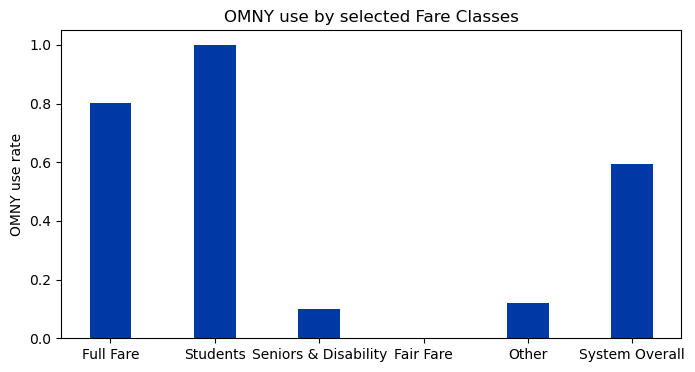

In [864]:
pretty_bar(list(omny_by_fare_class.keys()) + ['System Overall'], list(omny_by_fare_class.values()) + [overall_omny_rate],
          title="OMNY use by selected Fare Classes", ylabel="OMNY use rate")

Some conclusions can be drawn:
- As Student MetroCards have been replaced with Student OMNY cards, this fare class has a near total adoption of OMNY
- Full fare-paying riders have an OMNY adoption rate of about 80%, significantly higher than the system overall adoption rate of 59%
- Only about 10% of riders with Senior & Disability fare class cards have switched to OMNY
- Fair fare riders have negligibe rates of OMNY adoption

For the Student and Fair Fare classes, these can be attributed to current distribution and expiration patterns, as set by the MTA.

# 5. Comparing Fare Methods with Demographic Data

## 5.1 Preprocessing
The following cells contain the preprocessing steps for analysis with census data.

Only uncomment and run the next cell if you have not run the cells in 4.1 as it may take a while.

In [ ]:
#if 'fast_client' in globals():
    #subway_jgdf = get_subway_jgdf(fast_client)
#else:
    #subway_jgdf = get_subway_jgdf(slow_client, batch_size=1000)

In [ ]:
subway_jgdf = get_subway_jgdf(ep_client) # This may take a significant amount of time

The next cell further processes the data and may take a significant amount of time

In [216]:
subway_zcta_gdf = method_by_zcta(subway_jgdf, zcta_gdf)

Use the following cell to preview the data

In [ ]:
subway_zcta_gdf #run this cell to preview the data

In [880]:
subway_zcta_gdf.to_file('subway_zcta_gdf.gpkg', driver='GPKG') # export to file

**Start here if running from github**

In [881]:
subway_zcta_gdf = gpd.read_file('subway_zcta_gdf.gpkg') # by subway station

## 5.2 Mapping Results
We can plot the OMNY use rate for each Zip Code Tabulation Area

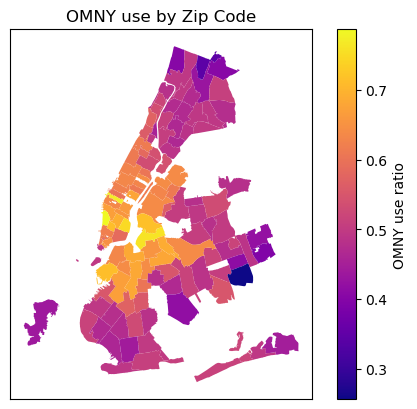

In [882]:
pretty_map(subway_zcta_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by Zip Code')

We can further highlight Manhattan, which has a higher densite of Zip Code Tabulation Areas.

Note: Grand Central Station has its own ZCTA, leading to a gap in Midtown East. A few Times Square and Bryant Park data points are labelled in ZCTA 10018, which mostly lays between 34th and 42nd streets. This is accounts for the brighter yellow region in Midtown West.

Note that the scale adjusts for the Manhattan-only data.

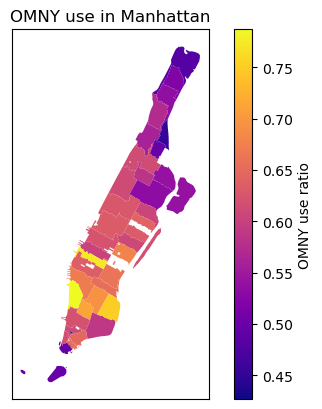

In [174]:
pretty_map(subway_zcta_gdf.loc[subway_zcta_gdf['borough'] == 'Manhattan'], 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use in Manhattan')

We may want to view this interactively

In [868]:
subway_zcta_gdf.explore('omny_ratio', cmap='plasma', tiles='CartoDB positron')

## 5.3 Income
Using the US Census Data for Zip Code Tabulation Areas, we can compare the use of OMNY vs. Metrocard across demographic factors, such as income

After we run the cells in section 3.2, we have a DataFrame called `income_df` that contains income data for the ZCTAs in New York State. We can use the `add_income_data()` function to add this data to our GeoDataFrame

In [883]:
income_df.to_parquet('income_df.parquet')

**Start here from GitHub**

In [884]:
income_df = pd.read_parquet("income_df.parquet") # by subway station

In [256]:
subway_zcta_income_gdf = add_census_data(subway_zcta_gdf, income_df, 'S1901_C01_012E', 'median_household_income', 'int')

We may want to map income to see if the map looks similar to areas of high OMNY use.

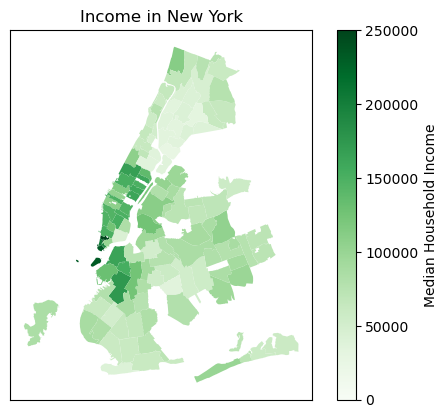

In [885]:
pretty_map(subway_zcta_income_gdf, 'median_household_income', cmap='Greens', legend_title='Median Household Income', title='Income in New York')

More important to this analysis, we will want to plot the two against each other.

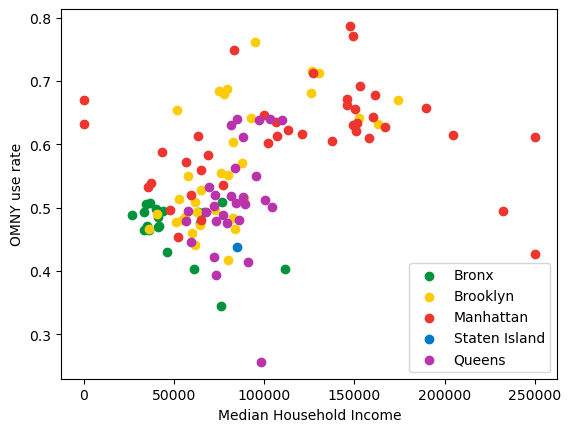

In [353]:
def colorize(borough):
    if borough == 'Manhattan': return '#EE352E'
    elif borough == 'Bronx': return '#00933C'
    elif borough == 'Brooklyn': return '#FCCC0A'
    elif borough == 'Queens': return '#B933AD'
    elif borough == 'Staten Island': return '#0078C6'

for boro in ['Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Queens']:
    plt.scatter(subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == boro,'median_household_income'], 
            subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == boro, 'omny_ratio'],
               c=colorize(boro), label=boro,)

plt.ylabel("OMNY use rate")
plt.xlabel("Median Household Income")
plt.legend()
plt.show()

We can use `sklearn` to see the Coefficient of Determination ("R squared" value) and find if there is any correlation between these variables

In [416]:
model = LinearRegression()
model.fit(subway_zcta_income_gdf['median_household_income'].values.reshape(-1, 1), subway_zcta_income_gdf['omny_ratio'])
score = model.score(subway_zcta_income_gdf['median_household_income'].values.reshape(-1, 1), subway_zcta_income_gdf['omny_ratio'])
print('R² score: ' + str(round(score, 6)))

R² score: 0.177036


They do not appear to be strongly correlated. The same is true when broken down by borough:

In [418]:
for borough in ['Manhattan', 'Bronx', 'Brooklyn', 'Queens',]:
    model = LinearRegression()
    model.fit(subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == borough, 
                  'median_household_income'].values.reshape(-1, 1), 
              subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == borough, 'omny_ratio'])
    score = model.score(subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == borough, 
                        'median_household_income'].values.reshape(-1, 1), 
                    subway_zcta_income_gdf.loc[subway_zcta_income_gdf['borough'] == borough, 'omny_ratio'])
    print(borough + " R² Score: " + str(round(score, 4)))

Manhattan R² Score: 0.0238
Bronx R² Score: 0.2535
Brooklyn R² Score: 0.368
Queens R² Score: 0.0844


## 5.4 Median Age
Using the US Census Data for Zip Code Tabulation Areas, we can compare the use of OMNY vs. Metrocard across demographic factors, such as income

We can use much of the same code for age as we did for income

In [886]:
age_df.to_parquet('age_df.parquet')

**Start here from GitHub**

In [887]:
age_df = pd.read_parquet('age_df.parquet')

In [888]:
subway_zcta_age_gdf = add_census_data(subway_zcta_gdf, age_df, 'S0101_C01_032E', 'median_age', 'float')
subway_zcta_age_gdf = add_census_data(subway_zcta_age_gdf, age_df, 'S0101_C02_023E', 'age_18_24', 'float')

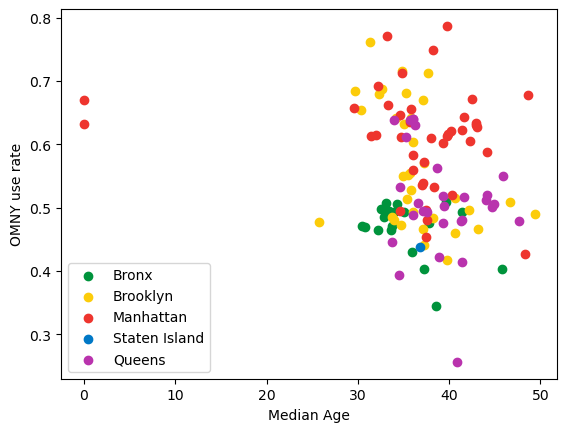

In [889]:
for boro in ['Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Queens']:
    plt.scatter(subway_zcta_age_gdf.loc[subway_zcta_age_gdf['borough'] == boro,'median_age'], 
            subway_zcta_age_gdf.loc[subway_zcta_age_gdf['borough'] == boro, 'omny_ratio'],
               c=colorize(boro), label=boro,)

plt.ylabel("OMNY use rate")
plt.xlabel("Median Age")
plt.legend()
plt.show()

The above graph shows no correlation between median age and OMNY adaptation. As noted before, stations near Colleges and Universities 

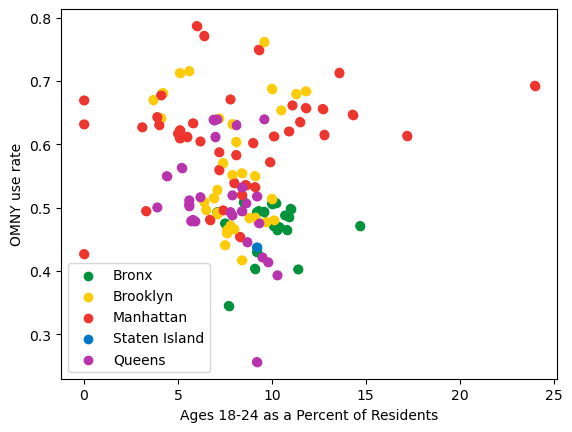

In [351]:
for boro in ['Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Queens']:
    plt.scatter(subway_zcta_age_gdf.loc[subway_zcta_age_gdf['borough'] == boro,'age_18_24'], 
            subway_zcta_age_gdf.loc[subway_zcta_age_gdf['borough'] == boro, 'omny_ratio'],
               c=colorize(boro), label=boro,)

plt.ylabel("OMNY use rate")
plt.xlabel("Ages 18-24 as a Percent of Residents")
plt.legend()
plt.show()

This graph does not appear to show a strong correlation. One observation of note is that there are two Manhattan ZCTAs with a high percentage of people between the ages of 18 and 24. In the cell below are the ZCTAs with the highest percentage of people in this age range. Looking at this data, we can see that these two data points contain NYU and Columbia University (the next several ZCTAs also contain or are adjacent to colleges and universities). These two data points have moderately high OMNY usage, but this alone does not point to a broader pattern

In [362]:
for index, row in subway_zcta_age_gdf.nlargest(5, 'age_18_24').iterrows():
    print('ZCTA: ' + str(index))
    print('Subway stations: ' + str(row['station_complexes']))
    print('OMNY use rate: ' + str(round(row['omny_ratio'], 3)))
    print()

ZCTA: 10003
Subway stations: ['8 St-NYU (R,W)', '3 Av (L)', '2 Av (F)', 'Astor Pl (6)', '14 St-Union Sq (L,N,Q,R,W,4,5,6)']
OMNY use rate: 0.693

ZCTA: 10027
Subway stations: ['135 St (C,B)', '125 St (A,C,B,D)', '125 St (1)', '116 St-Columbia University (1)', '125 St (2,3)']
OMNY use rate: 0.614

ZCTA: 10458
Subway stations: ['Bedford Park Blvd (B,D)', 'Kingsbridge Rd (B,D)', 'Fordham Rd (B,D)']
OMNY use rate: 0.471

ZCTA: 10038
Subway stations: ['Fulton St (A,C,J,Z,2,3,4,5)']
OMNY use rate: 0.647

ZCTA: 10012
Subway stations: ['Prince St (R,W)', 'Spring St (6)', 'Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)']
OMNY use rate: 0.713



## 5.5 Population Density

We can use `add_census_data` to add area and population figures, and write a few more lines to get population density

In [890]:
pop_df.to_parquet('pop_df.parquet')
area_df.to_parquet('area_df.parquet')

**Start here from Github**

In [891]:
pop_df = pd.read_parquet('pop_df.parquet')
area_df = pd.read_parquet('area_df.parquet')

In [396]:
subway_zcta_pop_gdf = add_census_data(subway_zcta_gdf, pop_df, 'P1_001N', 'Population')
subway_zcta_pop_gdf = add_census_data(subway_zcta_pop_gdf, area_df, 'AREALAND_SQMI', 'Area', type='float')
density = []
for index, row in subway_zcta_pop_gdf.iterrows():
    density += [row['Population'] / row['Area']]
subway_zcta_pop_gdf['pop_density'] = density

We can now graph the rate of OMNY use against population density

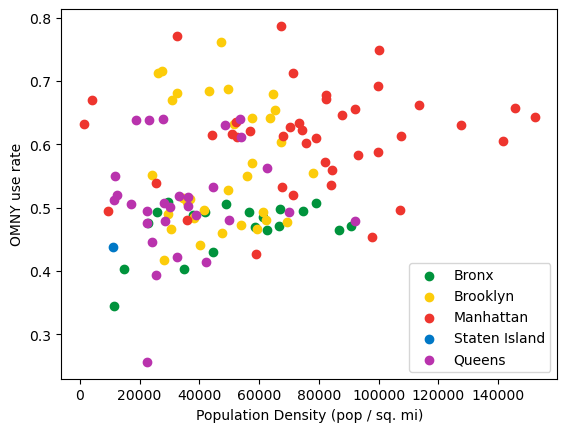

In [420]:
for boro in ['Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Queens']:
    plt.scatter(subway_zcta_pop_gdf.loc[subway_zcta_pop_gdf['borough'] == boro,'pop_density'], 
            subway_zcta_pop_gdf.loc[subway_zcta_pop_gdf['borough'] == boro, 'omny_ratio'],
               c=colorize(boro), label=boro,)

plt.ylabel("OMNY use rate")
plt.xlabel("Population Density (pop / sq. mi)")
plt.legend()
plt.show()

We can again use `sklearn` to see if these are correlated. They do not show a strong correlation.

In [415]:
model = LinearRegression()
model.fit(subway_zcta_pop_gdf['pop_density'].values.reshape(-1, 1), subway_zcta_pop_gdf['omny_ratio'])
score = model.score(subway_zcta_pop_gdf['pop_density'].values.reshape(-1, 1), subway_zcta_pop_gdf['omny_ratio'])
print('R² score: ' + str(round(score, 6)))

R² score: 0.093515


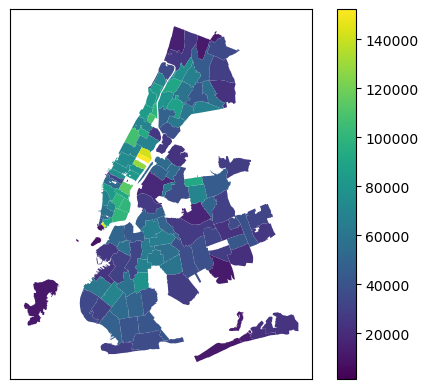

In [427]:
pretty_map(subway_zcta_pop_gdf, 'pop_density', cmap='viridis')

## 5.6 Model across Demographics
In addition to handling each demographic separately, we can create a model to see if a pattern emerges when we consider multiple demographics.

First, we will need to create a dataset with all available demographics

In [431]:
subway_zcta_demo_gdf = add_census_data(subway_zcta_pop_gdf, income_df, 'S1901_C01_012E', 'median_household_income', type='int')
subway_zcta_demo_gdf = add_census_data(subway_zcta_demo_gdf, age_df, 'S0101_C01_032E', 'median_age', type='float')
subway_zcta_demo_gdf = add_census_data(subway_zcta_demo_gdf, age_df, 'S0101_C02_023E', 'age_18_24', type='float')

We may want to isolate the x values for our model (the demographic factors being considered). To use borough data, we can use one-hot encoding.

In [467]:
x_dict = {'area': subway_zcta_demo_gdf['Area'], 'pop_density': subway_zcta_demo_gdf['pop_density'],
                'median_household_income': subway_zcta_demo_gdf['median_household_income'], 'median_age': subway_zcta_demo_gdf['median_age'], 
                'age_18_24': subway_zcta_demo_gdf['age_18_24'], 'Bronx':[0]*125, 'Brooklyn':[0]*125, 'Manhattan':[0]*125, 
              'Staten Island':[0]*125, 'Queens':[0]*125}

x_df = pd.DataFrame(x_dict, index=subway_zcta_demo_gdf['zcta'])
for index, row in subway_zcta_demo_gdf.iterrows():
    boro = row['borough']
    x_df.at[index, boro] = 1

Now, we can create a model using multiple demographic factors, along with borough information to predict OMNY use rates.

In [469]:
model = LinearRegression()
model.fit(x_df, subway_zcta_demo_gdf['omny_ratio'])
score = model.score(x_df, subway_zcta_demo_gdf['omny_ratio'])
print('R² score: ' + str(round(score, 6)))

R² score: 0.449858


This does not show a strong correlation, but it is better than prior results. We may want to try again with models that better handle non-linear relationships. Because the dataset is small, we need to be careful to prevent overfitting. Thus, we split a test set off from the dataset and use this to evaluate the model. We can run this several times to ensure repeatability

In [478]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

i = 0
while i < 5:
    X_train, X_test, y_train, y_test = train_test_split(x_df, subway_zcta_demo_gdf['omny_ratio'], test_size=0.2, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('R² score: ' + str(round(score, 6)))
    i+= 1

R² score: 0.464723
R² score: 0.477137
R² score: 0.475344
R² score: 0.433708
R² score: 0.457899


With both the linear and non-linear model, the R² score is similar at around 0.45. This means these models are better than random guessing, though there remains significant variance in the target (OMNY use rates) that the model cannot account for. There are a few reasons why this unimpressive score might still suggest some correlation:

- Because we are modelling human behavior, the target is inherently noisy, and is likely influenced by a number of factors that are very difficult to quantify or observe
- Using census data reduced the granularity of the dataset, as data is aggregated (in this case, over Zip Code). This makes it difficult to reflect the individual choices between OMNY and MetroCard that we are trying to analyze.

# 6. Change over Time
In addition to tracking OMNY use across stations, we can track OMNY adoption over time. Due to limited resources, this investigation will sample the first day of every month from February 2022 to September 2024

## 6.1 Preprocessing
This will require the preprocessing steps to be done again, which may take a while

In [521]:
timeline_df, failed_stations = get_timeline_data(ep_client)

In [524]:
timeline_gdf = format_geodata(timeline_df) 

### 6.1.1 Creating a New Table
We can use a function similar to `method_by_station` to break this data down by subway station and date

In [632]:
def method_by_time(mta_gdf):
    """takes a GeoDataFrame of subway station data and creates a new GeoDataFrame
        where each row represents one subway station on one day"""
    new_cols = ["date", "station_complex_id", "station_complex", "metrocard", "omny", "Total_Ridership",
                "omny_ratio", "borough", "georeference"]
    new_df = pd.DataFrame(columns=new_cols)
    #new_df.set_index("station_complex_id", inplace=False)
    idx = 0
    for index, row in mta_gdf.iterrows():
        payment_method = row['payment_method']
        ridership = int(float(row['ridership']))
        fare_class_category = row['fare_class_category']
        
        station_complex_id = row['station_complex_id']
        date = datetime.date(datetime.strptime(row['transit_timestamp'], '%Y-%m-%dT%H:%M:%S.%f'))
        matching_row = new_df[(new_df['date'] == date) & (new_df['station_complex_id'] == station_complex_id)]
        this_index = []

        if fare_class_category not in new_df.columns:
            new_df[fare_class_category] = 0

        if matching_row.empty: #create a new row for this index
            georeference = row["geometry"]
            station_complex = row['station_complex']
            new_row = {"date": date, "station_complex_id": station_complex_id, "station_complex": station_complex, 
                       "borough": row["borough"], "georeference": georeference}
            for col in new_df.columns:
                if col not in new_row:
                    new_row[col] = 0

            new_row_df = pd.DataFrame([new_row], index=[idx])
            new_row_df.loc[idx, payment_method] += ridership
            new_row_df.loc[idx, 'Total_Ridership'] += ridership
            new_row_df.loc[idx, fare_class_category] += ridership
            
            new_df = pd.concat([new_df, new_row_df])
            idx += 1
            print('new row created for ' + str(station_complex) + ' at ' + str(date))
        else:
            this_index = matching_row.index[0]
            new_df.at[this_index, payment_method] += ridership #add the ridership to the correct method
            new_df.at[this_index, "Total_Ridership"] += ridership #add to the total ridership
            new_df.at[this_index, fare_class_category] += ridership

    omny_ratio = []
    for index, row in new_df.iterrows():
        this_ratio = row['omny']/ row['Total_Ridership']
        omny_ratio += [this_ratio]
        
    new_df['omny_ratio'] = omny_ratio

    new_gdf = gpd.GeoDataFrame(new_df, geometry='georeference', crs="EPSG:4326")
    return new_gdf

### 
---------------------

The following is another preprocessing step that will take a while

In [ ]:
station_times_gdf = method_by_time(timeline_gdf) #will take a lot of time

In [ ]:
station_times_gdf

The following cells can be used to save and load these preprocessing steps to save time in the future

In [525]:
timeline_gdf.to_file('timeline_gdf.gpkg', driver='GPKG')

In [634]:
station_times_gdf.to_file('station_times_gdf.gpkg', driver='GPKG')

Read the files below

In [ ]:
timeline_gdf = gpd.read_file('timeline_gdf.gpkg')

**Start here from Github and continue to the rest of section 6**

In [ ]:
station_times_gdf.read_file('station_times_gdf.gpkg')

## 6.2 Plotting Change over Time

We can plot the OMNY use over time for one station to easily visualize the data. Change `station_id` to switch which station is being plotted

[]

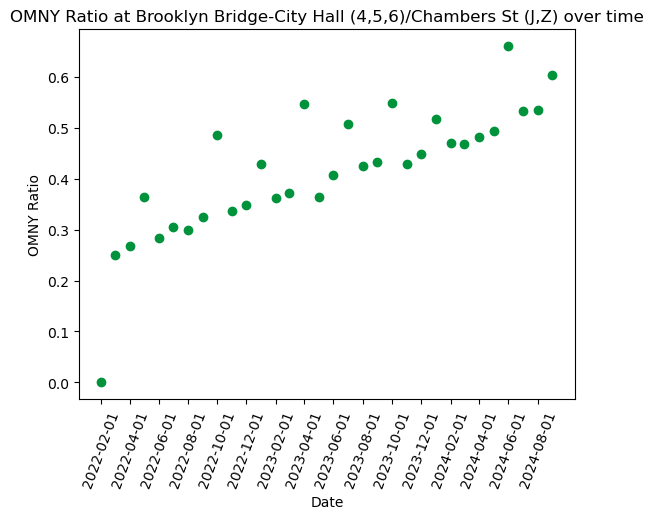

In [803]:
station_id = 622

station_name = station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'station_complex'].values[0]
station_plot = plt.scatter(station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'date'], 
            station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'omny_ratio'], color='#00933C')
plt.ylabel("OMNY Ratio")
plt.xlabel("Date")
plt.title("OMNY Ratio at " + station_name + " over time")
plt.xticks(get_date_list()[::2], get_date_list()[::2], rotation=70)  # Rotate for better readability
plt.plot()

Below is a vizualization for all of the data

In [713]:
violin_data = [station_times_gdf.loc[station_times_gdf['date'] == datetime.date(datetime.strptime(date, '%Y-%m-%d')), 'omny_ratio'].values 
               for date in get_date_list()]
x_positions = list(range(1, len(get_date_list()) + 1))

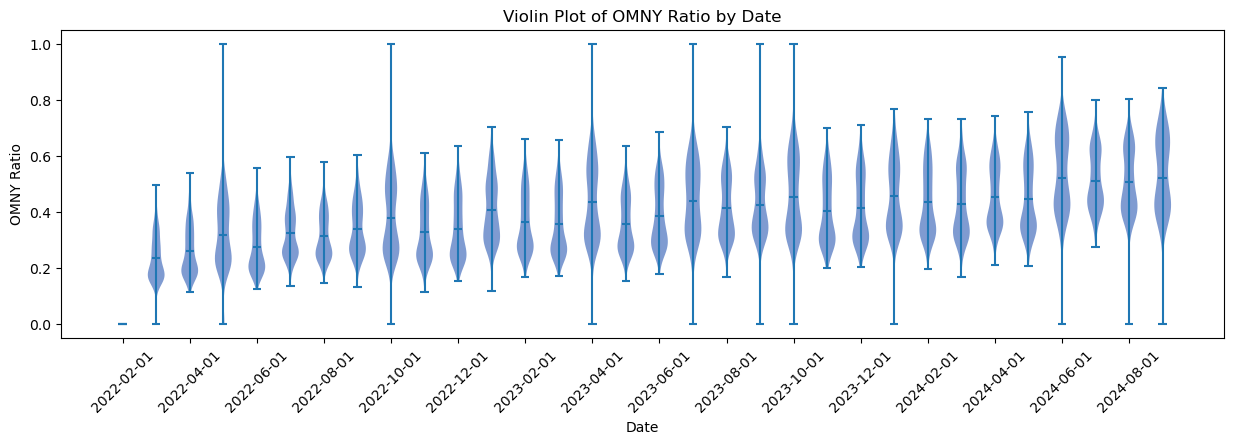

In [714]:
plt.figure(figsize=(15, 4))
vp = plt.violinplot(violin_data, x_positions, showmeans=True)

for body in vp['bodies']:
    body.set_facecolor('#0039A5')
    body.set_alpha(0.5)
plt.xlabel("Date")
plt.ylabel("OMNY Ratio")
plt.title("Violin Plot of OMNY Ratio by Date")
plt.xticks(x_positions[::2], get_date_list()[::2], rotation=45)  # Rotate for better readability
plt.show()

## 6.3 Modelling Future Station OMNY Use
We can use these values to predict future OMNY use in the system

First, we can create a model for one station's OMNY adoption over time. Change `station_id` to select station. The score represents how well the model is a fit for the data, with a score of 1.0 indicating the model accounts for all variation in the data. With human behavior data, such as fare payment method, data may be noisy, so a good model may stil not have an excellent score.

In [724]:
station_id = 622

station_name = station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'station_complex'].values[0]
station_model = LinearRegression()
station_model.fit(np.array(x_positions).reshape(-1, 1), station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'omny_ratio'])
score = station_model.score(np.array(x_positions).reshape(-1, 1), station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 
                            'omny_ratio'])

print(station_name + " R² Score: " + str(round(score, 4)))

Brooklyn Bridge-City Hall (4,5,6)/Chambers St (J,Z) R² Score: 0.6749


We can visually test this by plotting the line on the scatter plot:

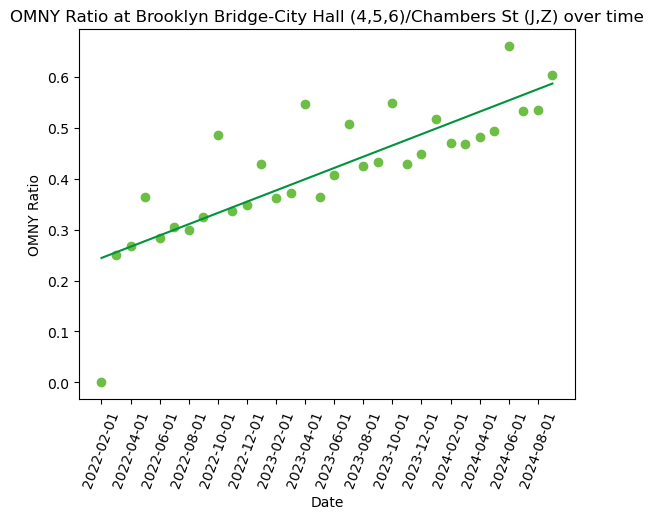

In [872]:
plt.scatter(x_positions, station_times_gdf.loc[station_times_gdf['station_complex_id'] == str(station_id), 'omny_ratio'], color='#6CBE45')
plt.plot(x_positions, station_model.predict(np.array(x_positions).reshape(-1, 1)), label='Regression Line', color='#00933C')
plt.ylabel("OMNY Ratio")
plt.xlabel("Date")
plt.title("OMNY Ratio at " + station_name + " over time")
plt.xticks(x_positions[::2], get_date_list()[::2], rotation=70) 
plt.show()

We can use the model to predict when a certain percentage of a station's fare payments are made with OMNY. Change `target_omny_use` to choose this value. 

In [874]:
target_omny_use = 0.95
print('Current OMNY use rate at ' + station_name + ': ' + 
      str(round(subway_station_gdf.loc[subway_station_gdf['station_complex_id'] == str(station_id), 'omny_ratio'].values[0], 4)))
x_target = (target_omny_use - station_model.intercept_) / station_model.coef_[0]
future_date = np.datetime64(get_date_list()[0], 'M') + np.timedelta64(int(x_target - 1), 'M')
print('Estimated month when ' + str(target_omny_use * 100) + '% of riders at ' + station_name + 'use OMNY: ' + str(future_date))


Current OMNY use rate at Brooklyn Bridge-City Hall (4,5,6)/Chambers St (J,Z): 0.5647
Estimated month when 95.0% of riders at Brooklyn Bridge-City Hall (4,5,6)/Chambers St (J,Z)use OMNY: 2027-05


## 6.4 Modelling Future System OMNY Use
We can also model future OMNY use for the entire system

We will need to aggregate the data to get one data point for each date representing systemwide OMNY usage

In [783]:
def whole_system_timeline(station_times_gdf):
    """Converts station_times_gdf to a smaller DataFrame for the whole system"""
    new_cols = ['date', 'metrocard', 'omny', 'Total_Ridership']
    new_df = pd.DataFrame(columns=new_cols)
    for index, row in station_times_gdf.iterrows():
        date = row['date']
        if not( date in new_df['date'].values ): # add new row for this date
            new_data_dict = {'date':date, 'metrocard':0, 'omny':0, 'Total_Ridership':0}
            new_row = pd.DataFrame([new_data_dict])
            new_df = pd.concat([new_df, new_row], ignore_index=True)

        matching_row = new_df.loc[new_df['date'] == date]
        this_index = matching_row.index[0]
        new_df.at[this_index, 'metrocard'] += row['metrocard']
        new_df.at[this_index, 'omny'] += row['omny']
        new_df.at[this_index, 'Total_Ridership'] += row['Total_Ridership']

    omny_ratios = []
    for index, row in new_df.iterrows():
        omny_ratios += [(row['omny'] / row['Total_Ridership'])]
    new_df['omny_ratio'] = omny_ratios

    return new_df

In [784]:
system_timeline_df = whole_system_timeline(station_times_gdf)

We can plot the system change over time as a single data point

[]

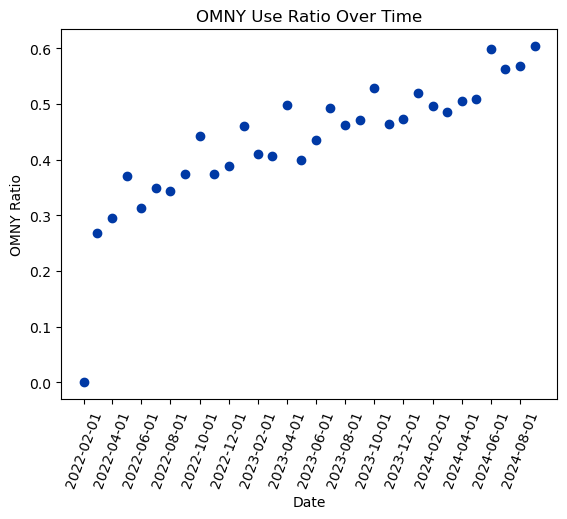

In [807]:
nycta_plot = plt.scatter(system_timeline_df['date'].values, system_timeline_df['omny_ratio'].values, color='#0039A5')
plt.ylabel("OMNY Ratio")
plt.xlabel("Date")
plt.title("OMNY Use Ratio Over Time")
plt.xticks(get_date_list()[::2], get_date_list()[::2], rotation=70) 
plt.plot()

We can create a model to represent the change in OMNY use over time, much like the model for one station

In [876]:
system_model = LinearRegression()
system_model.fit(np.array(x_positions).reshape(-1, 1), system_timeline_df['omny_ratio'].values)
score = station_model.score(np.array(x_positions).reshape(-1, 1), system_timeline_df['omny_ratio'].values)

print("R² Score: " + str(round(score, 4)))

R² Score: 0.699


We get an R² score of about 0.7, which means our model performs relatively well on this data (especially considering human behavior data is often very noisy). We can test this visually by plotting it:

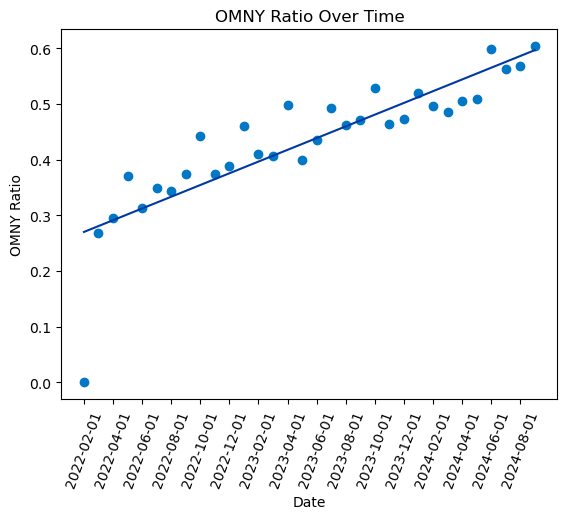

In [815]:
nycta_plot = plt.scatter(x_positions, system_timeline_df['omny_ratio'].values, color='#0078C6')
plt.plot(x_positions, system_model.predict(np.array(x_positions).reshape(-1, 1)), label='Regression Line', color='#0039A5')
plt.ylabel("OMNY Ratio")
plt.xlabel("Date")
plt.title("OMNY Ratio Over Time")
plt.xticks(x_positions[::2], get_date_list()[::2], rotation=70) 
plt.show()

In a similar vein to data from one station, we can use the model to predict when OMNY usage will reach a certain threshold. Change `target_omny_use` to set this threshold

In [878]:
target_omny_use = 0.95
try: print('Current OMNY use rate: ' + str(round(overall_omny_rate, 4))) #from section 4
except: pass
x_target = (target_omny_use - system_model.intercept_) / system_model.coef_[0]
future_date = np.datetime64(get_date_list()[0], 'M') + np.timedelta64(int(x_target - 1), 'M')
print('Estimated month when ' + str(target_omny_use * 100) + '% of riders use OMNY: ' + str(future_date))

Current OMNY use rate: 0.5946
Estimated month when 95.0% of riders use OMNY: 2027-06


# 7. Detailed Maps & Charts
This section contains better or more detailed versions of some of the maps and charts to be included in the report

The following is the borough boundaries from <https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm>

In [547]:
boro_path = "boroughs/borough_boundaries.shp"
borough_boundaries_gdf = gpd.read_file(boro_path)
borough_boundaries_gdf.to_crs("EPSG:4326")

,boro_code,boro_name,shape_area,shape_leng,geometry
0,3.0,Brooklyn,1.934143e+09,728147.130565,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
1,5.0,Staten Island,1.623619e+09,325910.306061,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,1.0,Manhattan,6.366461e+08,360037.525777,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,2.0,Bronx,1.187175e+09,463180.578878,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
4,4.0,Queens,3.041418e+09,888197.010944,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [894]:
borough_boundaries_gdf.to_file('boro_boundaries_gdf.gpkg', driver='GPKG')

**Start here from GitHub**

In [895]:
borough_boundaries_gdf = gpd.read_file('boro_boundaries_gdf.gpkg')

In [896]:
def big_map(data, this_parameter, cmap='plasma', legend_title=None, mark_size=12, title=None, boroughs=None):
    legend_kw = {'label': legend_title, 'orientation':'vertical'}
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    if boroughs == 'all':
            borough_boundaries_gdf.plot(color='gainsboro', edgecolor='none', linewidth=1, ax=ax)
    elif boroughs != None:
        #use the borough code / codes
        borough_boundaries_gdf.loc[borough_boundaries_gdf['boro_code'] == boroughs].plot(color='gainsboro', edgecolor='none', linewidth=1, ax=ax)
    
    plot = data.plot(this_parameter, cmap=cmap, legend=True, markersize=mark_size, legend_kwds=legend_kw, ax=ax)
        
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_frame_on(True)  # Ensure the boundary is visible
    plt.title(title)

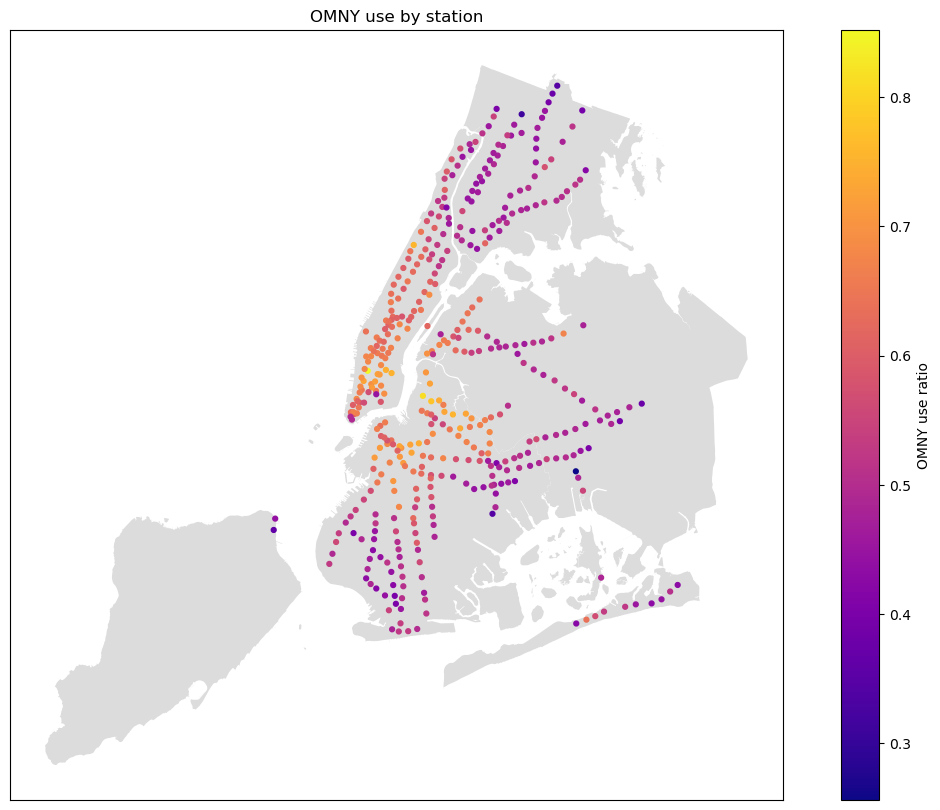

In [897]:
big_map(subway_station_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by station', boroughs='all')

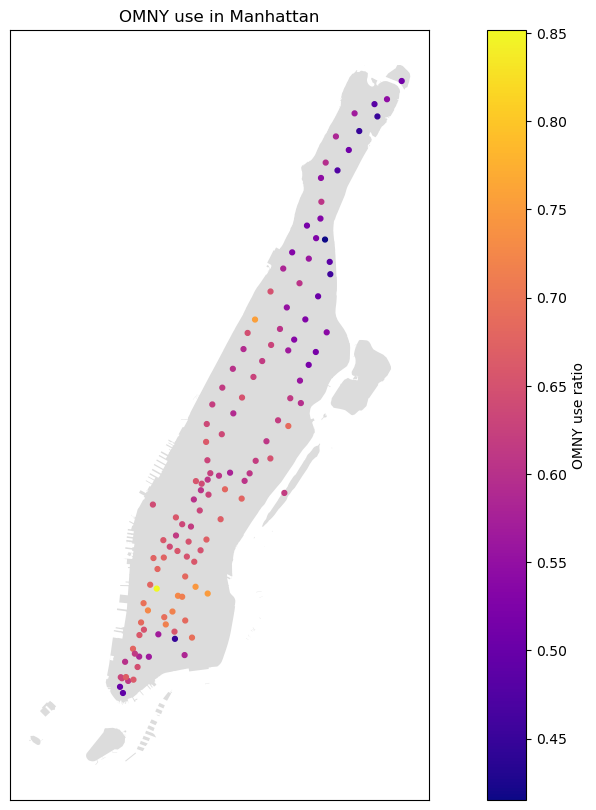

In [555]:
big_map(subway_station_gdf.loc[subway_station_gdf['borough'] == 'Manhattan'], 'omny_ratio', legend_title='OMNY use ratio',
        title='OMNY use in Manhattan', boroughs=1)

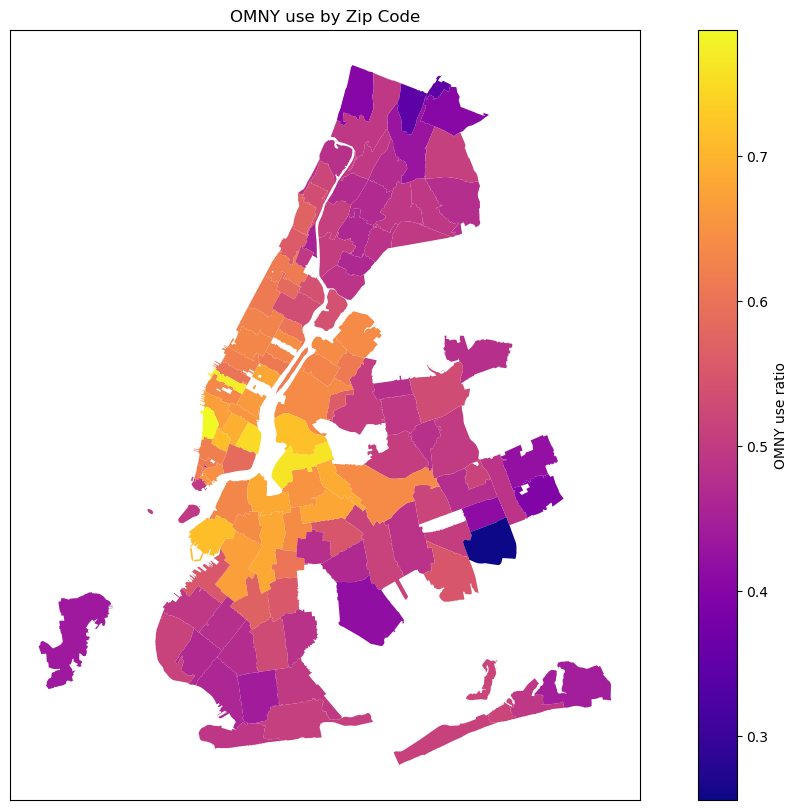

In [560]:
big_map(subway_zcta_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by Zip Code')

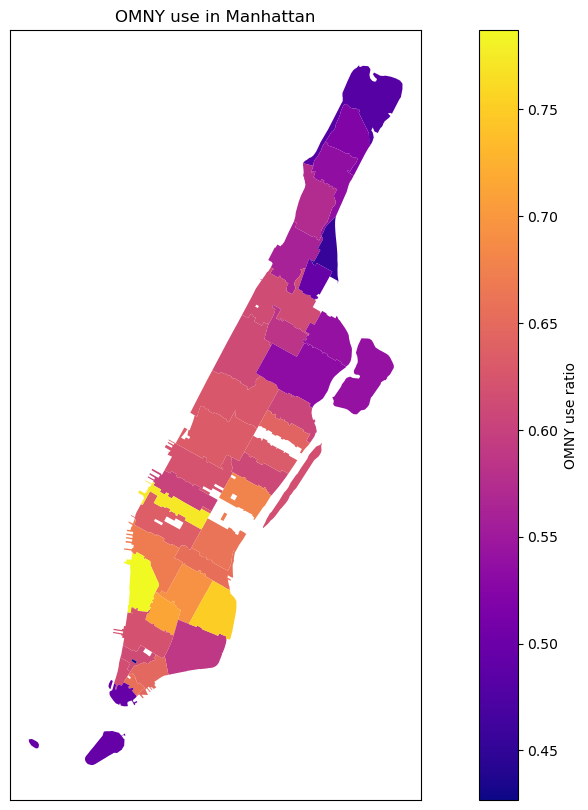

In [564]:
big_map(subway_zcta_gdf.loc[subway_zcta_gdf['borough'] == 'Manhattan'], 'omny_ratio', 
        legend_title='OMNY use ratio', title='OMNY use in Manhattan')

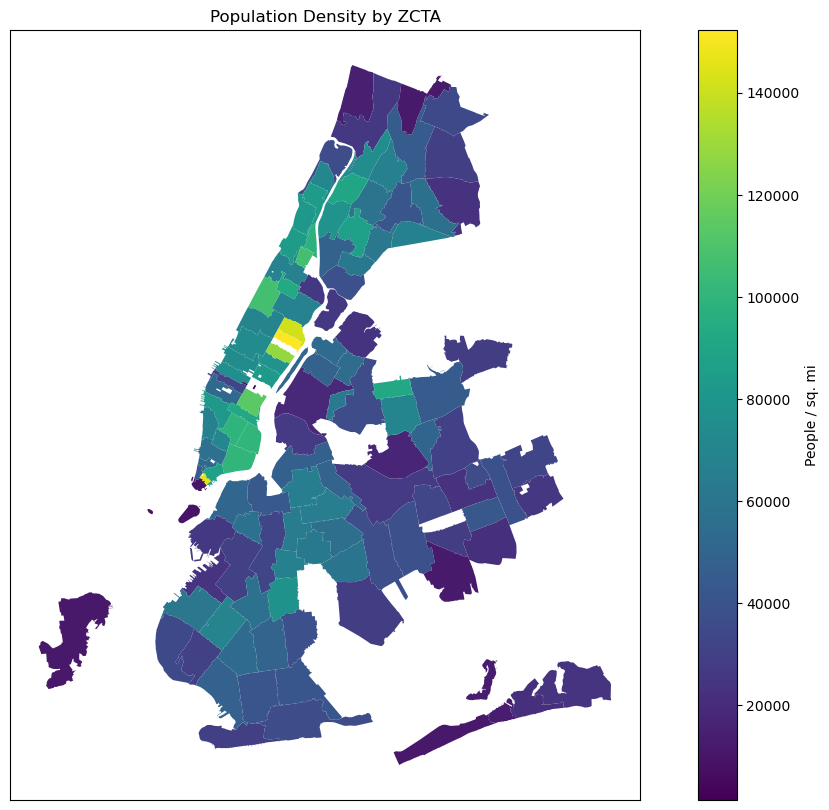

In [870]:
big_map(subway_zcta_pop_gdf, 'pop_density', cmap='viridis', legend_title='People / sq. mi', title='Population Density by ZCTA',)

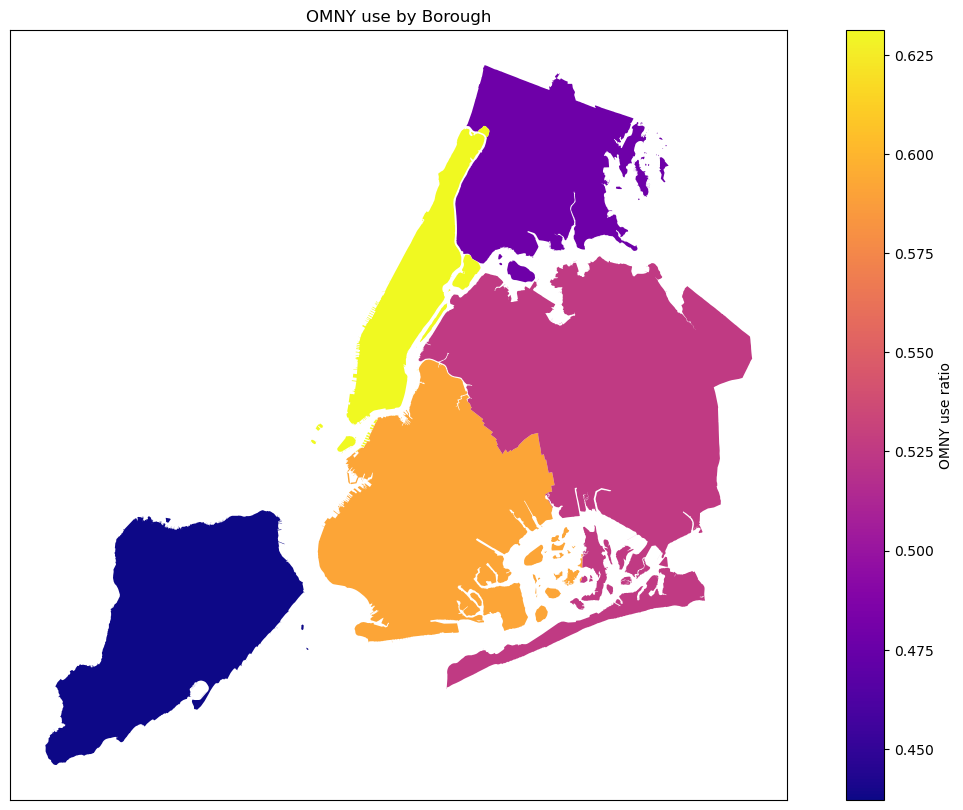

In [852]:
big_map(boro_gdf, 'omny_ratio', legend_title='OMNY use ratio', title='OMNY use by Borough', cmap='plasma')

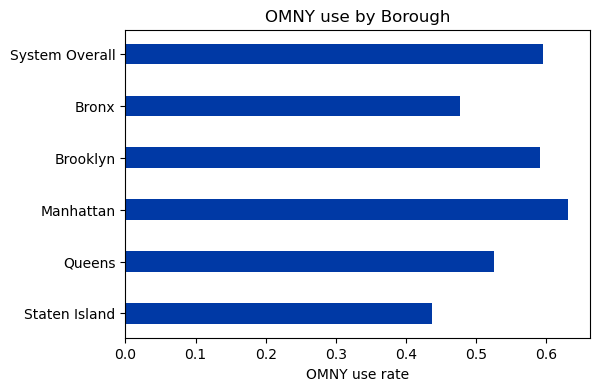

In [859]:
pretty_bar(list(borough_rates.keys())[::-1] + ['System Overall'], list(borough_rates.values())[::-1] + [overall_omny_rate],
          title="OMNY use by Borough", xlabel="OMNY use rate", horiz=True, figsize=(6,4))

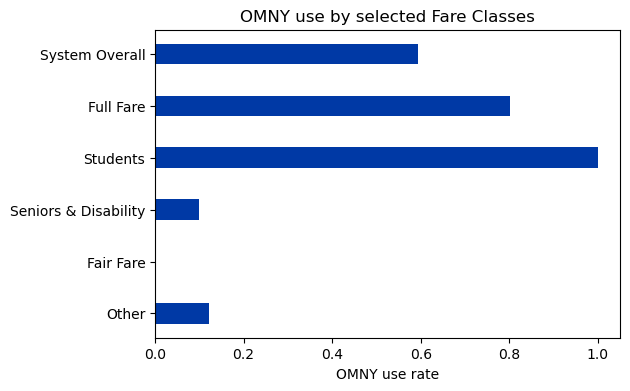

In [866]:
pretty_bar(list(omny_by_fare_class.keys())[::-1] + ['System Overall'], list(omny_by_fare_class.values())[::-1] + [overall_omny_rate],
          title="OMNY use by selected Fare Classes", xlabel="OMNY use rate", horiz=True, figsize=(6,4))